In [1]:
# Import the necessary modules

import pandas as pd, numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
%matplotlib inline

We will use a for loop to go through all images in each directory, read them, re-size them and store them as arrays as well as a df. In the following step, we will use the array to select only the lung area for building our model

All dataframes created for future use in models currently have image data in the form of an array. This has to be modified in the following steps before splitting the data into train and test set

In [2]:
# Step 1: A for loop to read, resize and store all image and mask data in a dataframe

# Step 1.1: Get the path of the directory that contains the data
path = "../data"
os.chdir(path)  #Go to the directory specified abv


# Step 1.2:  Create a list of categories and subfolders for each category to loop through
categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
sub_types = ['images', 'masks']

# Step 1.3: Create a list to store image and mask data separately- we will need this to select the lung area
image_data = []
image_name = [] # stores the name of the image
labels_img = []# the label or category of each image or mask

mask_data = []
mask_name = [] # stores the name of the mask
labels_mk = []


# Step 1.4: Loop through and read the 1st image and mask of each group 
for category in categories:
  
    #Loop through each sub-folder to load the images
    for sub_type in sub_types:
        
        file_path = os.path.join(path, category, sub_type)
        

        for image in os.listdir(file_path):
            
            if sub_type == 'images':

                # Step 1: Get the label for each image
                label = image.split('-')[0]
                #label_cat = categories.index(label)# 0: Normal, 1: COVID, 2: Lung Opacity, 3: Pneumonia
                labels_img.append(label)

                # Step 2: Read each image
                Xray = cv2.imread(os.path.join(file_path, image), cv2.IMREAD_GRAYSCALE)# reads every image
     
                # Step 3: Re-size each raw X-ray image to 256*256 pixels
                Xray_resize = cv2.resize(Xray, (256, 256))
        
                # Step 4: Store image data 
                image_data.append(Xray_resize)
                image_name.append(image)# name of the image
                #print(np.array(image_data))   
                    
                # Step 5: create a df with this data
                image_df = pd.DataFrame({'name': image_name, 'image': image_data, 'label': labels_img})
                     

            elif sub_type == 'masks':

                # Step 1: Get the label for each mask
                label_mk = image.split('-')[0]
                labels_mk.append(label_mk)
                    
                # Step 2: Read the mask
                mask = cv2.imread(os.path.join(file_path, image), cv2.IMREAD_GRAYSCALE)

                    # check the size of the mask. They are 256*256 pixels
                    #print(mask.shape)

                    #Note: No re-sizing needed for masks as they are already 256*256

                # Step 3: Store image data as an array
                mask_data.append(mask)
                mask_name.append(image)

                # STep 4:reate a df with this data
                mask_df = pd.DataFrame({'name': mask_name, 'image': mask_data, 'label': labels_mk})
                    
                    

Text(0.5, 1.0, 'Lung area of a normal individual')

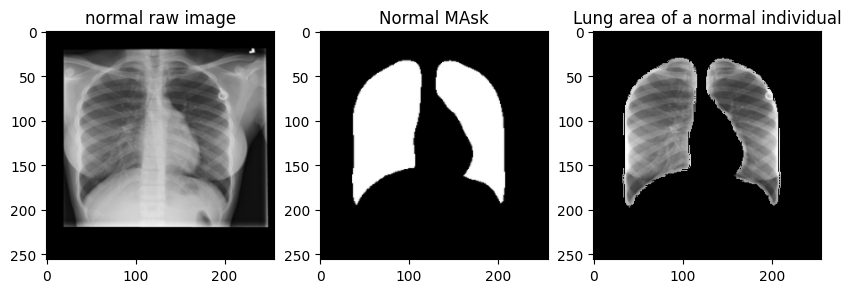

In [3]:
# Step 2.1:  Define a function to cut out only the lung region of the x ray for analysis
def filter_roi(image, mask):
    
    # Apply the mask to the image
    roi = cv2.bitwise_and(image, image, mask = mask)
    
    # Filter the ROI (e.g., apply additional blurring or other filters)
    #filtered_roi = cv2.GaussianBlur(roi, (15, 15), 0)
    
    return roi

# Step 2.2: TEST RUN for the function
# Step 2.2.1: first, read and re-size the image 
def read_resize_img(image):

    # Step1: Read the image in gray scale
    Xray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Step1.2: resize the image to 256*256 pixels
    Xray_resize = cv2.resize(Xray, (256, 256))

    return Xray_resize

# Step 2.2.2: test the filter function on re-sized images
#A test run for images
normal = read_resize_img('../data/Normal/images/Normal-1.png')
normal_mk = read_resize_img('../data/Normal/masks/Normal-1.png')
roi_normal = filter_roi(normal, normal_mk)

# FOr a COVID series
covid = read_resize_img('../data/COVID/images/COVID-1.png')
covid_mk = read_resize_img('../data/COVID/masks/COVID-1.png')
roi_covid = filter_roi(covid, covid_mk)


# FOr an LO series
lo = read_resize_img('../data/Lung_Opacity/images/Lung_Opacity-1.png')
lo_mk = read_resize_img('../data/Lung_Opacity/masks/Lung_Opacity-1.png')
roi_lo = filter_roi(lo, lo_mk)

# FOr a VP series
vp = read_resize_img('../data/Viral Pneumonia/images/Viral Pneumonia-1.png')
vp_mk = read_resize_img('../data/Viral Pneumonia/masks/Viral Pneumonia-1.png')
roi_vp = filter_roi(vp, vp_mk)

# plot
fig = plt.figure(figsize=(10,15))

# images
plt.subplot(131)
plt.imshow(normal, cmap = 'gray')
plt.title('normal raw image')

plt.subplot(132)
plt.imshow(normal_mk, cmap="gray")
plt.title('Normal MAsk')

plt.subplot(133)
plt.imshow(roi_normal, cmap="gray")
plt.title('Lung area of a normal individual')



In [12]:
normal

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
# View the df created in step 1
image_df.head()
mask_df.head()


## Step 3:  Run the ROI selection function to selection only the lung region of every image

# Step 3.1: create an empty list to add pixel intensitie of only the lung region
lung_area = []  # to add only the pixels in the lung area


# Step 3.2: For every image and corresponding mask, select the lung region
for index,(image, mask) in enumerate(zip(image_data, mask_data)):

    mask = cv2.resize(mask, (256, 256))
    ## The ROI selection function to select the lung region 
    roi_lung = filter_roi(image, mask)

    # Add this data into a list
    lung_area.append(roi_lung)
                          


In [13]:
image_data[0].shape

(256, 256)

In [14]:
mask_data[0].shape

(299, 299)

In [20]:
len(lung_area)

21165

The roi selection of the lung area seems to have worked


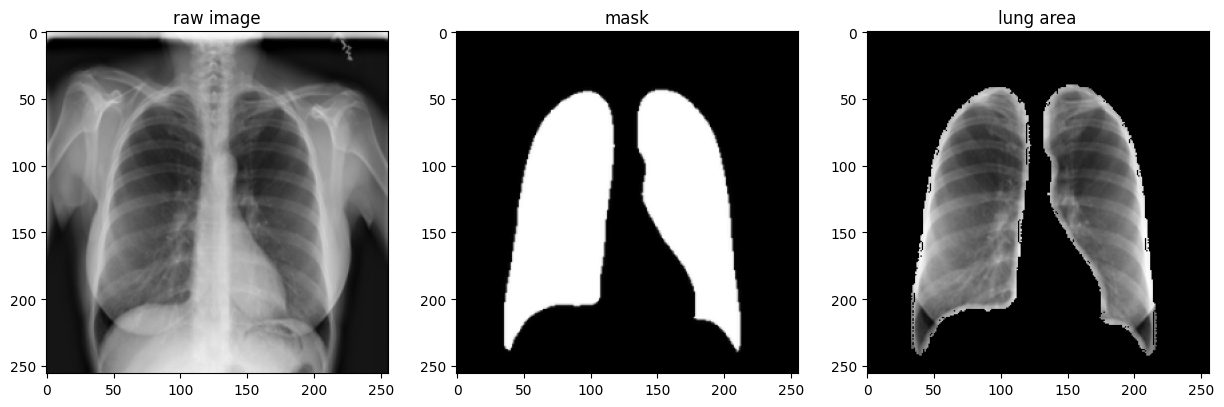

In [5]:
# Step 3.3: Plot to check if the roi selection worked- for some random images

for i in np.random.choice(np.arange(0, len(image_data)), size = 1):
    img = image_data[i] 
    mask = cv2.resize(mask_data[i], (256, 256))
    lung = lung_area[i]
  
    fig = plt.figure(figsize=(15,15))
    plt.subplot(131),plt.imshow(img, cmap = 'gray'),plt.title('raw image')
    plt.subplot(132),plt.imshow(mask, cmap = 'gray'),plt.title('mask')
    plt.subplot(133),plt.imshow(lung, cmap = 'gray'),plt.title('lung area')
    
  
print('The roi selection of the lung area seems to have worked')

In [6]:
print(lung_area.index)
print(image_df.head())

<built-in method index of list object at 0x169847180>
              name                                              image   label
0  Normal-6196.png  [[247, 244, 241, 239, 236, 233, 231, 228, 228,...  Normal
1  Normal-7288.png  [[233, 228, 223, 220, 217, 215, 214, 211, 210,...  Normal
2  Normal-1821.png  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  Normal
3  Normal-4781.png  [[18, 11, 6, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, ...  Normal
4  Normal-4959.png  [[206, 200, 192, 170, 130, 85, 58, 41, 27, 20,...  Normal


              name   label                                         lung_image
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


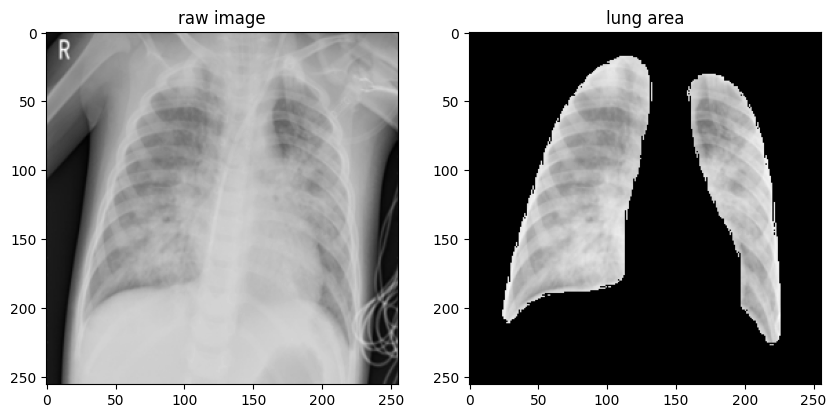

In [7]:
# Step 4: Merge the data into a df for all the subsequent steps

# STep 4.1: Create a df that contains the image name, pixels from just the lung area and the label
lung_data = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'lung_image': lung_area})

print(lung_data.head())# The merge was done considering that the order of images is the same in the df and the lung_area array

#Step 4.2: plot randome images to see if the image and the lung area are indeed of the same raw image- SORT OF A REDUNDANT STEP from step 3.3
for i in np.random.choice(np.arange(0, len(lung_data)), size = 1):
    img = image_data[i] 
    lung = lung_data['lung_image'][i]
  
    fig = plt.figure(figsize=(10,10))
    plt.subplot(121),plt.imshow(img, cmap = 'gray'),plt.title('raw image')
    plt.subplot(122),plt.imshow(lung, cmap = 'gray'),plt.title('lung area')


Text(0.5, 1.0, 'med 7 + canny 0-50')

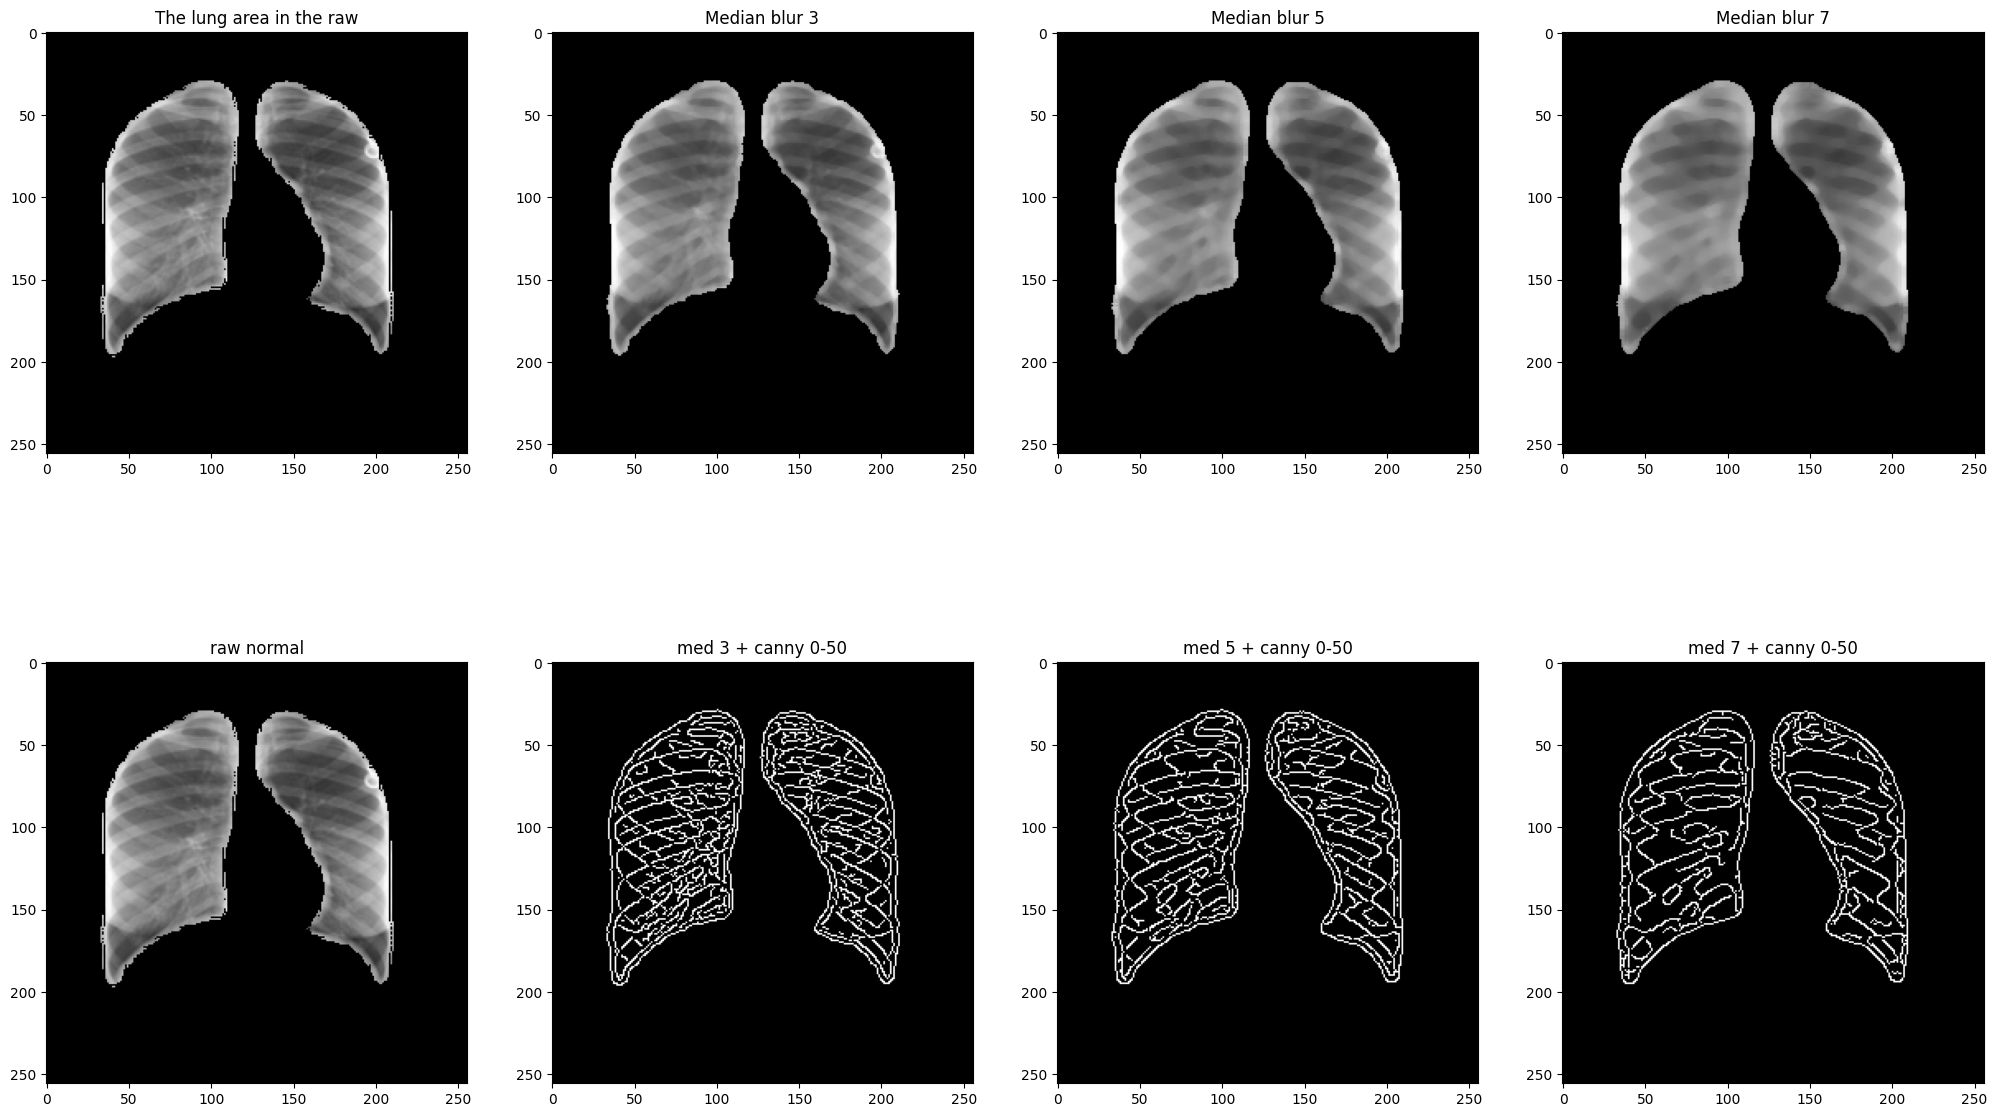

In [8]:
############+++++++++++++++++++++++++++++++++++++  Step 5: Use different filters to check how we can eliminate unwanted noise ++++++++++++++++++#######################

# Step 5.1 : median blur + Canny for normal

# Median blur with 3 different ksizes- DETAILED ANALYSIS 
### STep 5.1.1: median blur for normal
med_normal_1 = cv2.medianBlur(roi_normal, ksize = 3)
med_normal_2 = cv2.medianBlur(roi_normal, ksize = 5)
med_normal_3 = cv2.medianBlur(roi_normal, ksize = 7)

# Step 5.1.2: Canny detection for Normal

med1_canny_nor = cv2.Canny(med_normal_1, 0, 50)
med2_canny_nor = cv2.Canny(med_normal_2, 0, 50)
med3_canny_nor = cv2.Canny(med_normal_3, 0, 50)

## Step 5.1.3 PLot
fig = plt.figure(figsize=(25,15))

# images- normal

plt.subplot(241)
plt.imshow(roi_normal, cmap = 'gray')
plt.title('The lung area in the raw')

plt.subplot(242)
plt.imshow(med_normal_1, cmap="gray")
plt.title('Median blur 3')

plt.subplot(243)
plt.imshow(med_normal_2, cmap="gray")
plt.title('Median blur 5')

plt.subplot(244)
plt.imshow(med_normal_3, cmap="gray")
plt.title('Median blur 7')

plt.subplot(245)
plt.imshow(roi_normal, cmap = 'gray')
plt.title('raw normal')

plt.subplot(246)
plt.imshow(med1_canny_nor, cmap="gray")
plt.title('med 3 + canny 0-50')

plt.subplot(247)
plt.imshow(med2_canny_nor, cmap="gray")
plt.title('med 5 + canny 0-50')

plt.subplot(248)
plt.imshow(med3_canny_nor, cmap="gray")
plt.title('med 7 + canny 0-50')


Median blur and Canny edge detection detects noise as well and we observe the rib cage and some fibres that are caught as structures with edge detection
Median blur 5 and 7 is sort of creating some shpaes which are actually not in the original image. SO, this will not be useful for us
Median blur 3, 3 and a canny filter of 50 looks promising although in normal it catches quite a bit of noise


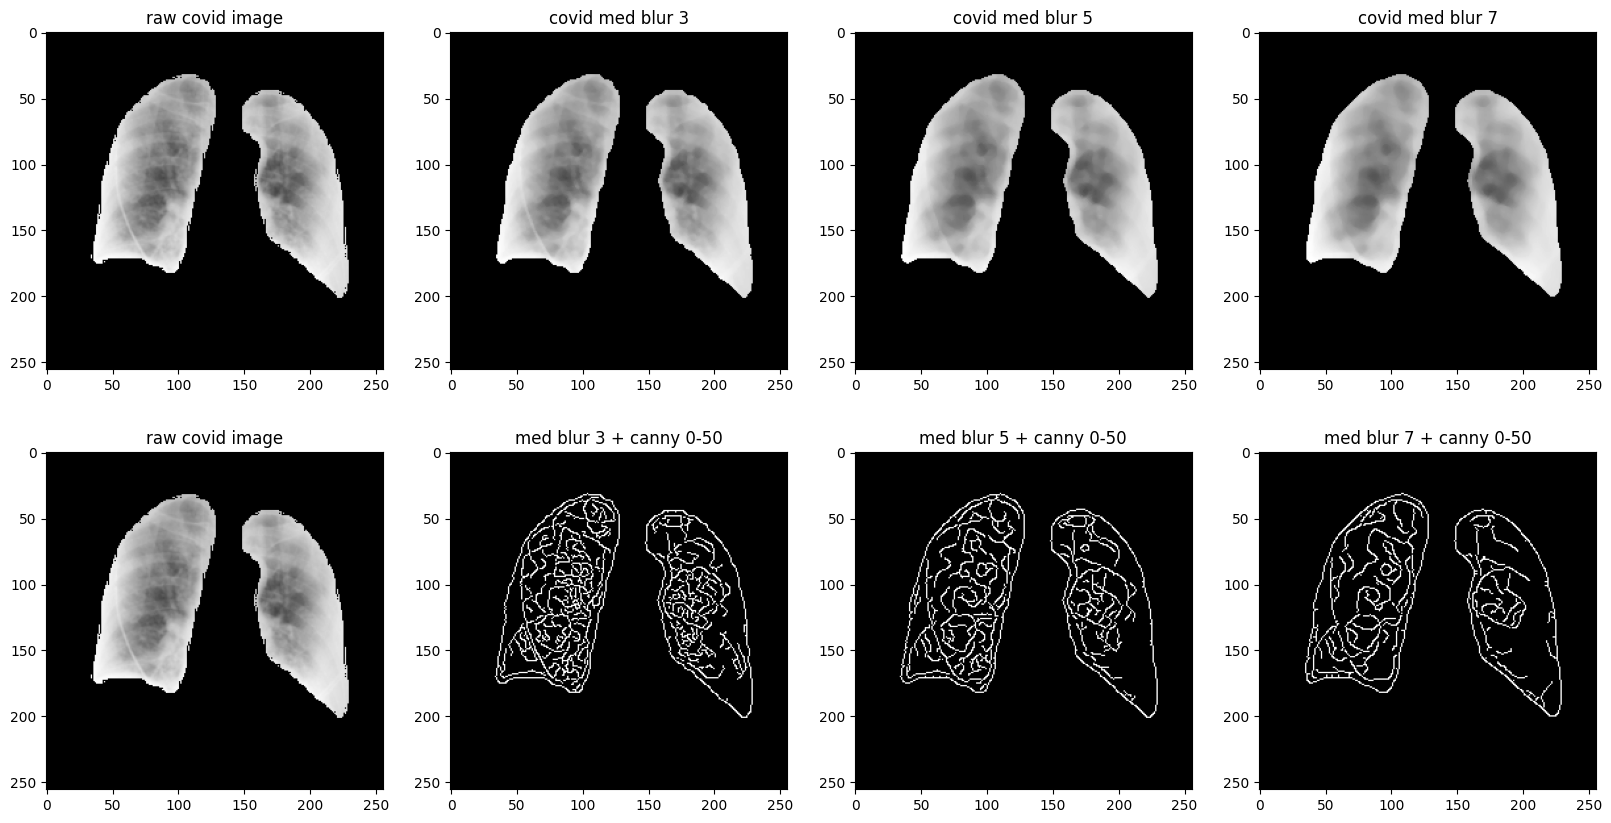

In [9]:
### Step 5.2: Canny edge detection for Median blurred images in COVID samples

###Step 5.2.1: median blur for covid
med_covid_1 = cv2.medianBlur(roi_covid, ksize = 3)
med_covid_2 = cv2.medianBlur(roi_covid, ksize = 5)
med_covid_3 = cv2.medianBlur(roi_covid, ksize = 7)

# STep 5.2.2: Canny detection for COVID
med1_canny = cv2.Canny(med_covid_1, 0, 50)
med2_canny = cv2.Canny(med_covid_2, 0, 50)
med3_canny = cv2.Canny(med_covid_3, 0, 50)



# Step 5.2.3: plot to see how median blur changes the image
# images- covid
fig = plt.figure(figsize=(20,10))
plt.subplot(241),plt.imshow(roi_covid, cmap = 'gray'),plt.title('raw covid image')
plt.subplot(242),plt.imshow(med_covid_1, cmap = 'gray'),plt.title('covid med blur 3')
plt.subplot(243),plt.imshow(med_covid_2, cmap = 'gray'),plt.title('covid med blur 5')
plt.subplot(244),plt.imshow(med_covid_3, cmap = 'gray'),plt.title('covid med blur 7')

plt.subplot(245),plt.imshow(roi_covid, cmap = 'gray'),plt.title('raw covid image')
plt.subplot(246),plt.imshow(med1_canny, cmap = 'gray'),plt.title('med blur 3 + canny 0-50')
plt.subplot(247),plt.imshow(med2_canny, cmap = 'gray'),plt.title('med blur 5 + canny 0-50')
plt.subplot(248),plt.imshow(med3_canny, cmap = 'gray'),plt.title('med blur 7 + canny 0-50')


print ('Median blur and Canny edge detection detects noise as well and we observe the rib cage and some fibres that are caught as structures with edge detection')# best')

print('Median blur 5 and 7 is sort of creating some shpaes which are actually not in the original image. SO, this will not be useful for us')
print('Median blur 3, 3 and a canny filter of 50 looks promising although in normal it catches quite a bit of noise')


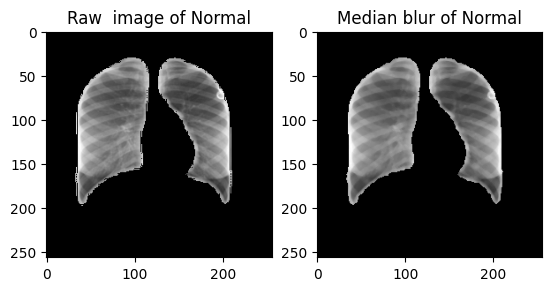

In [10]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############

######### +++++++++++++++++ Step 5.3: Median filter (function)
ksize = [3]# set based on the above run

def median_fil(image, ksize):

    for value in ksize:
        xray_med_fil = cv2.medianBlur(image, value) # the median blur

        #plot the image
        #med_fil_plot = plt.imshow(Xray_med_fil, cmap = 'gray')
        #plt.title('The median blur of ksize', value)

    return xray_med_fil


#Test if the function works
normal_med_fil = median_fil(roi_normal, ksize)# The median blur is only brighthening the white areas even more and blurring the image. WHat we want would be edge detection

# plot in graph
plt.subplot(121),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw  image of Normal')
plt.subplot(122),plt.imshow(normal_med_fil, cmap = 'gray'),plt.title('Median blur of Normal');



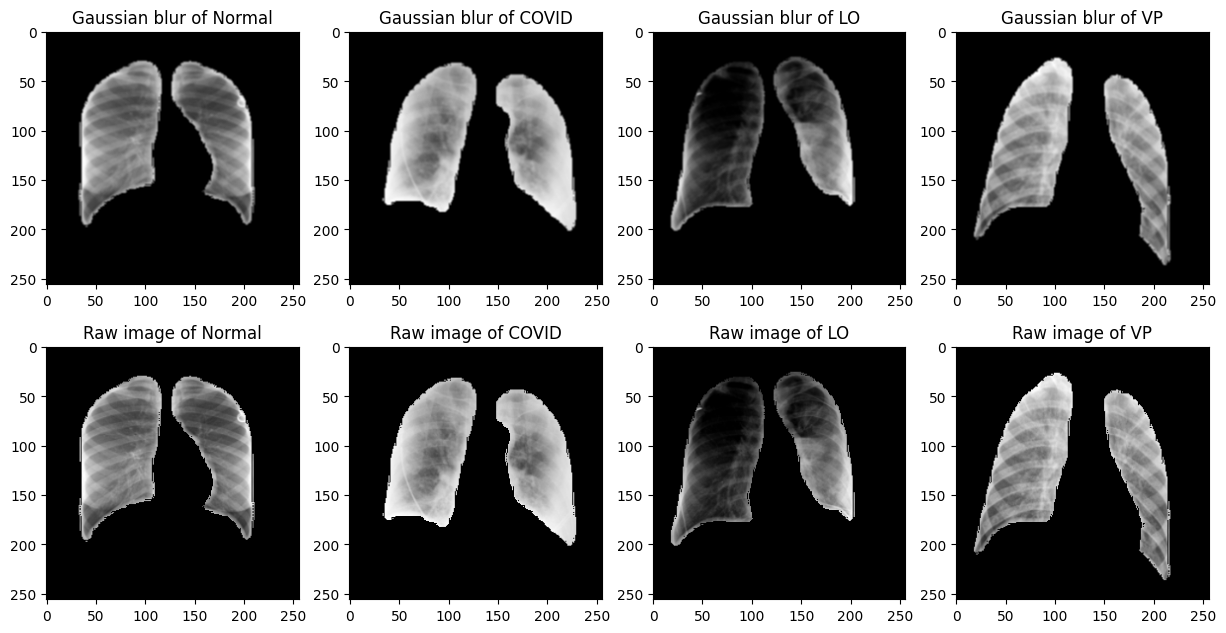

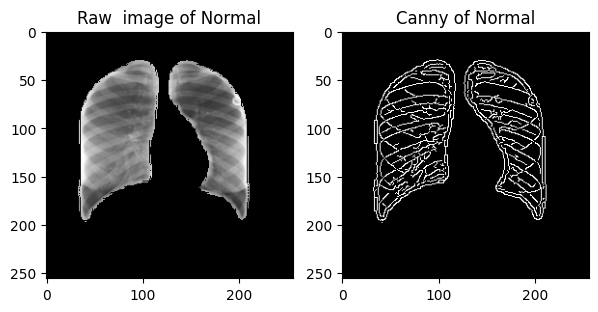

In [11]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############


### Step 5.3: Gaussian filter
#kernel = (3, 3)# , (5, 5), (7, 7)]

def Gau_fil(image):

    # Gaussian blur for the image
    xray_Gau = cv2.GaussianBlur(image, (3, 3), 0)

    return xray_Gau


#Test if the function works
normal_Gau = Gau_fil(roi_normal)# works well with Canny edge detection
covid_Gau = Gau_fil(roi_covid)
lo_Gau = Gau_fil(roi_lo)
vp_Gau = Gau_fil(roi_vp)

# plot in graph
fig = plt.figure(figsize=(15,15))
plt.subplot(141),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw image of Normal')

plt.subplot(142),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Raw image of COVID')

plt.subplot(143),plt.imshow(roi_lo, cmap = 'gray'),plt.title('Raw image of LO')

plt.subplot(144),plt.imshow(roi_vp, cmap = 'gray'),plt.title('Raw image of VP')

plt.subplot(241),plt.imshow(normal_Gau, cmap = 'gray'),plt.title('Gaussian blur of Normal')

plt.subplot(242),plt.imshow(covid_Gau, cmap = 'gray'),plt.title('Gaussian blur of COVID')

plt.subplot(243),plt.imshow(lo_Gau, cmap = 'gray'),plt.title('Gaussian blur of LO')

plt.subplot(244),plt.imshow(vp_Gau, cmap = 'gray'),plt.title('Gaussian blur of VP');


### Step 5.4: Canny filter using Gaussian blur as base

# Setting the values of the parameters
#min_canny = 0
#max_canny = 75

# Function for Canny
def canny_fil(image, min_canny, max_canny):

    #  Canny edge detection
    xray_canny = cv2.Canny(image, min_canny, max_canny)

    return xray_canny


#Test if the function works
normal_Gau_canny = canny_fil(normal_Gau, min_canny = 0, max_canny = 75 )# works well with Canny edge detection

# plot in graph
fig = plt.figure(figsize=(7,7))
plt.subplot(121),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw  image of Normal')
plt.subplot(122),plt.imshow(normal_Gau_canny, cmap = 'gray'),plt.title('Canny of Normal');





A gaussian blur (3, 3) kernel is best along with a Canny between 50 -75 as max


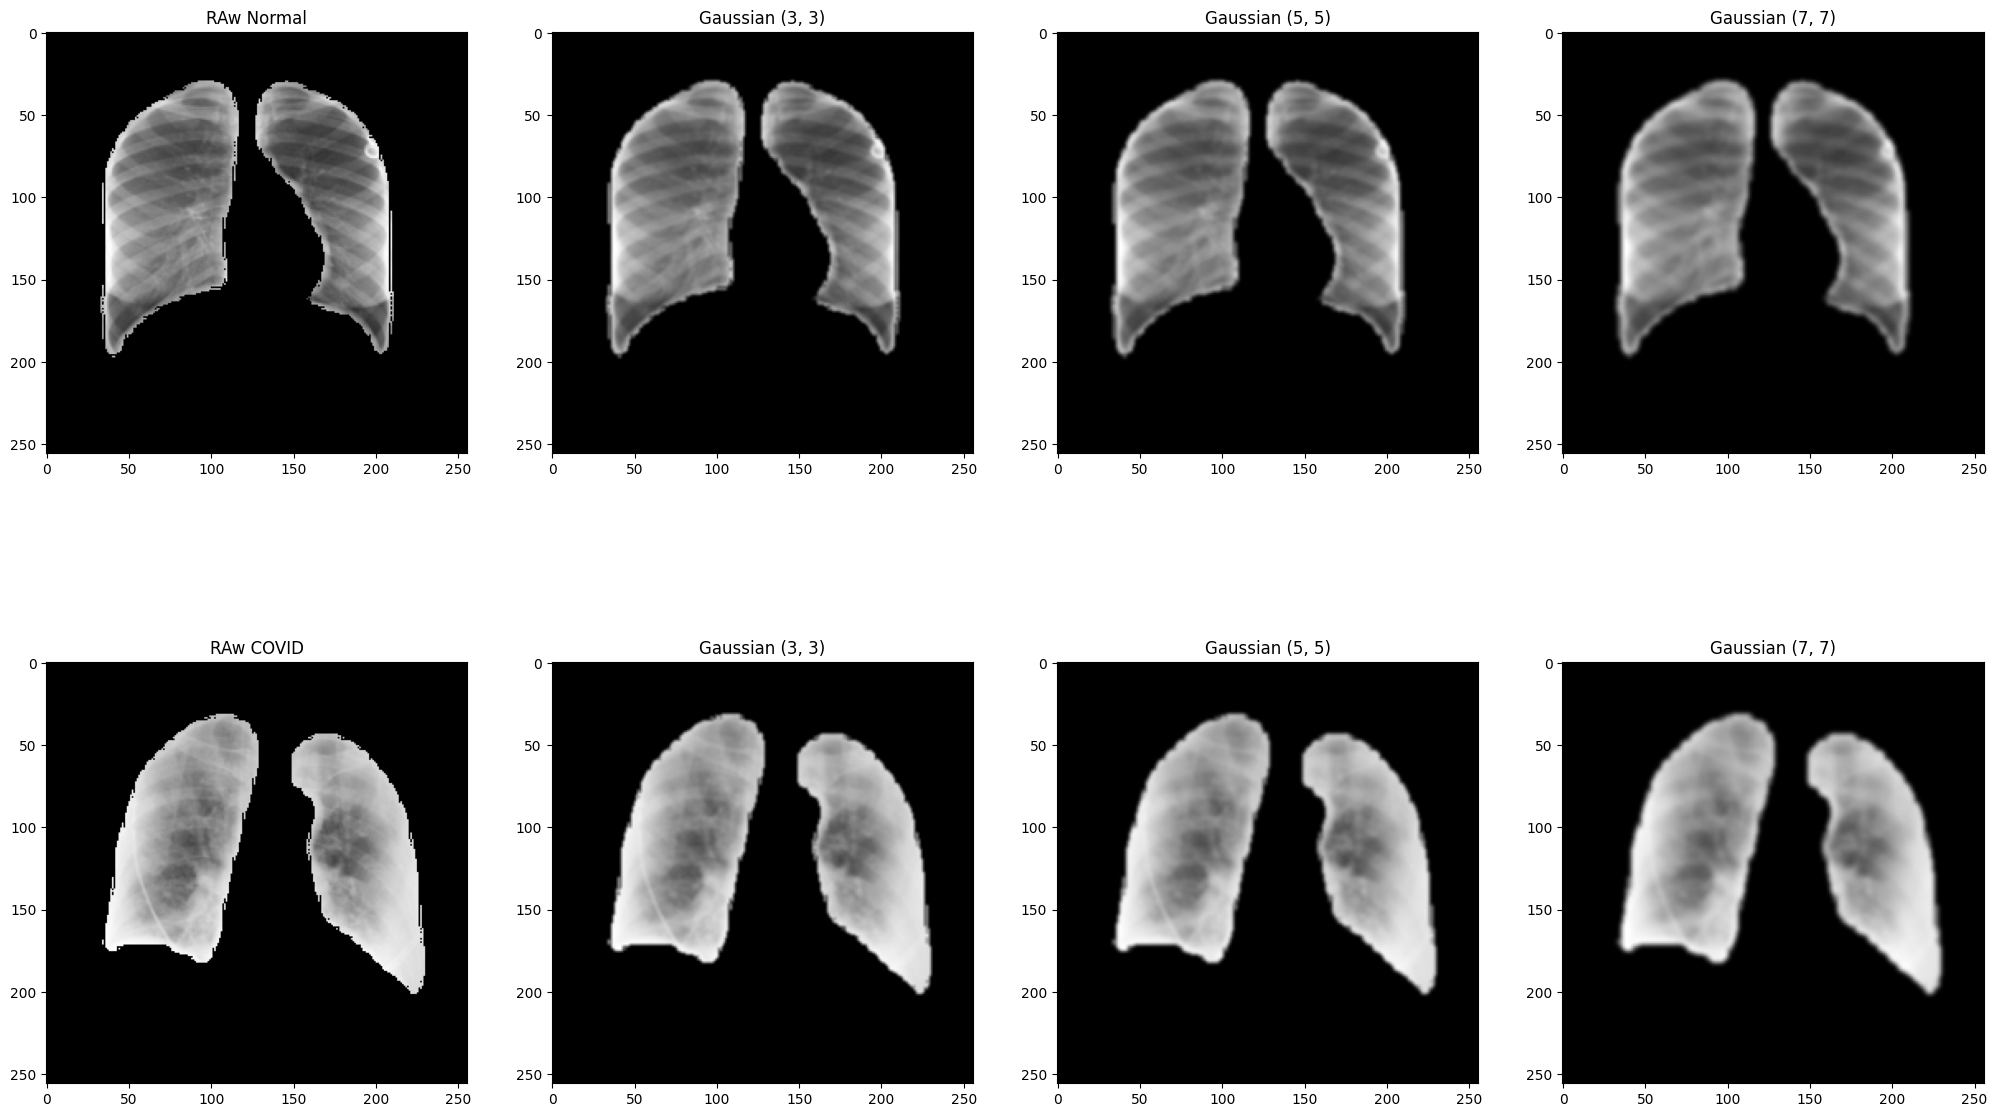

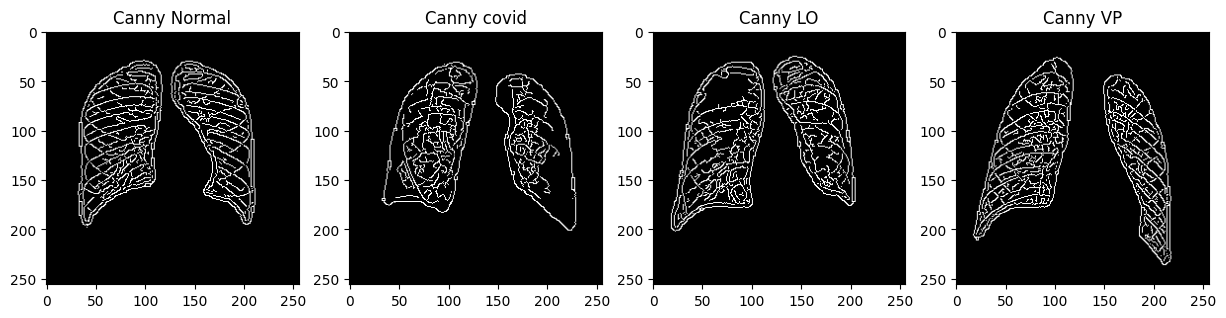

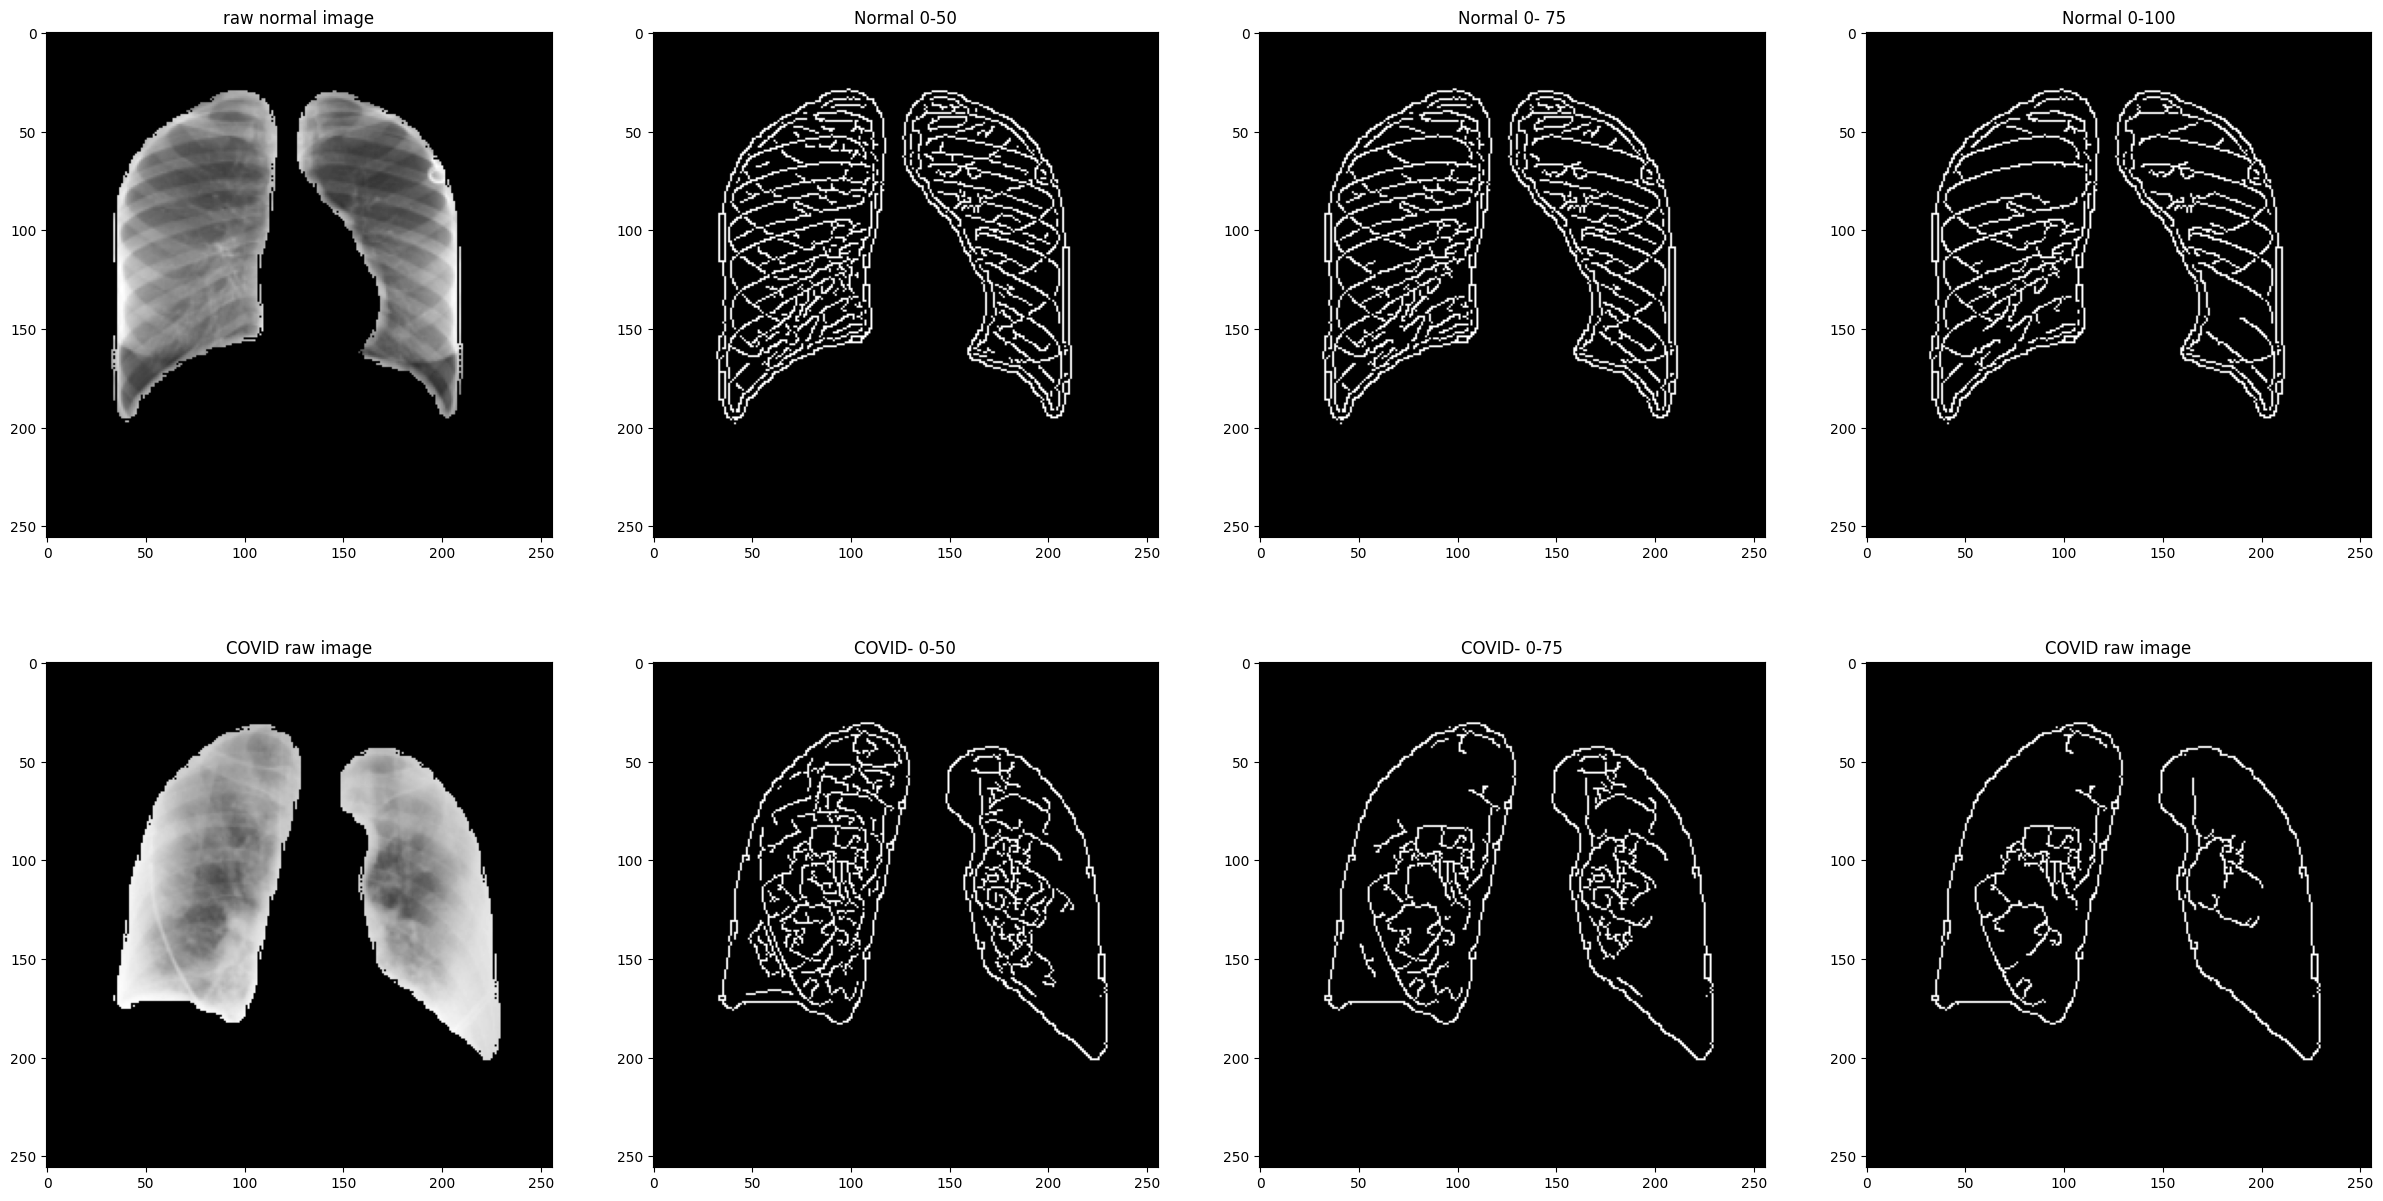

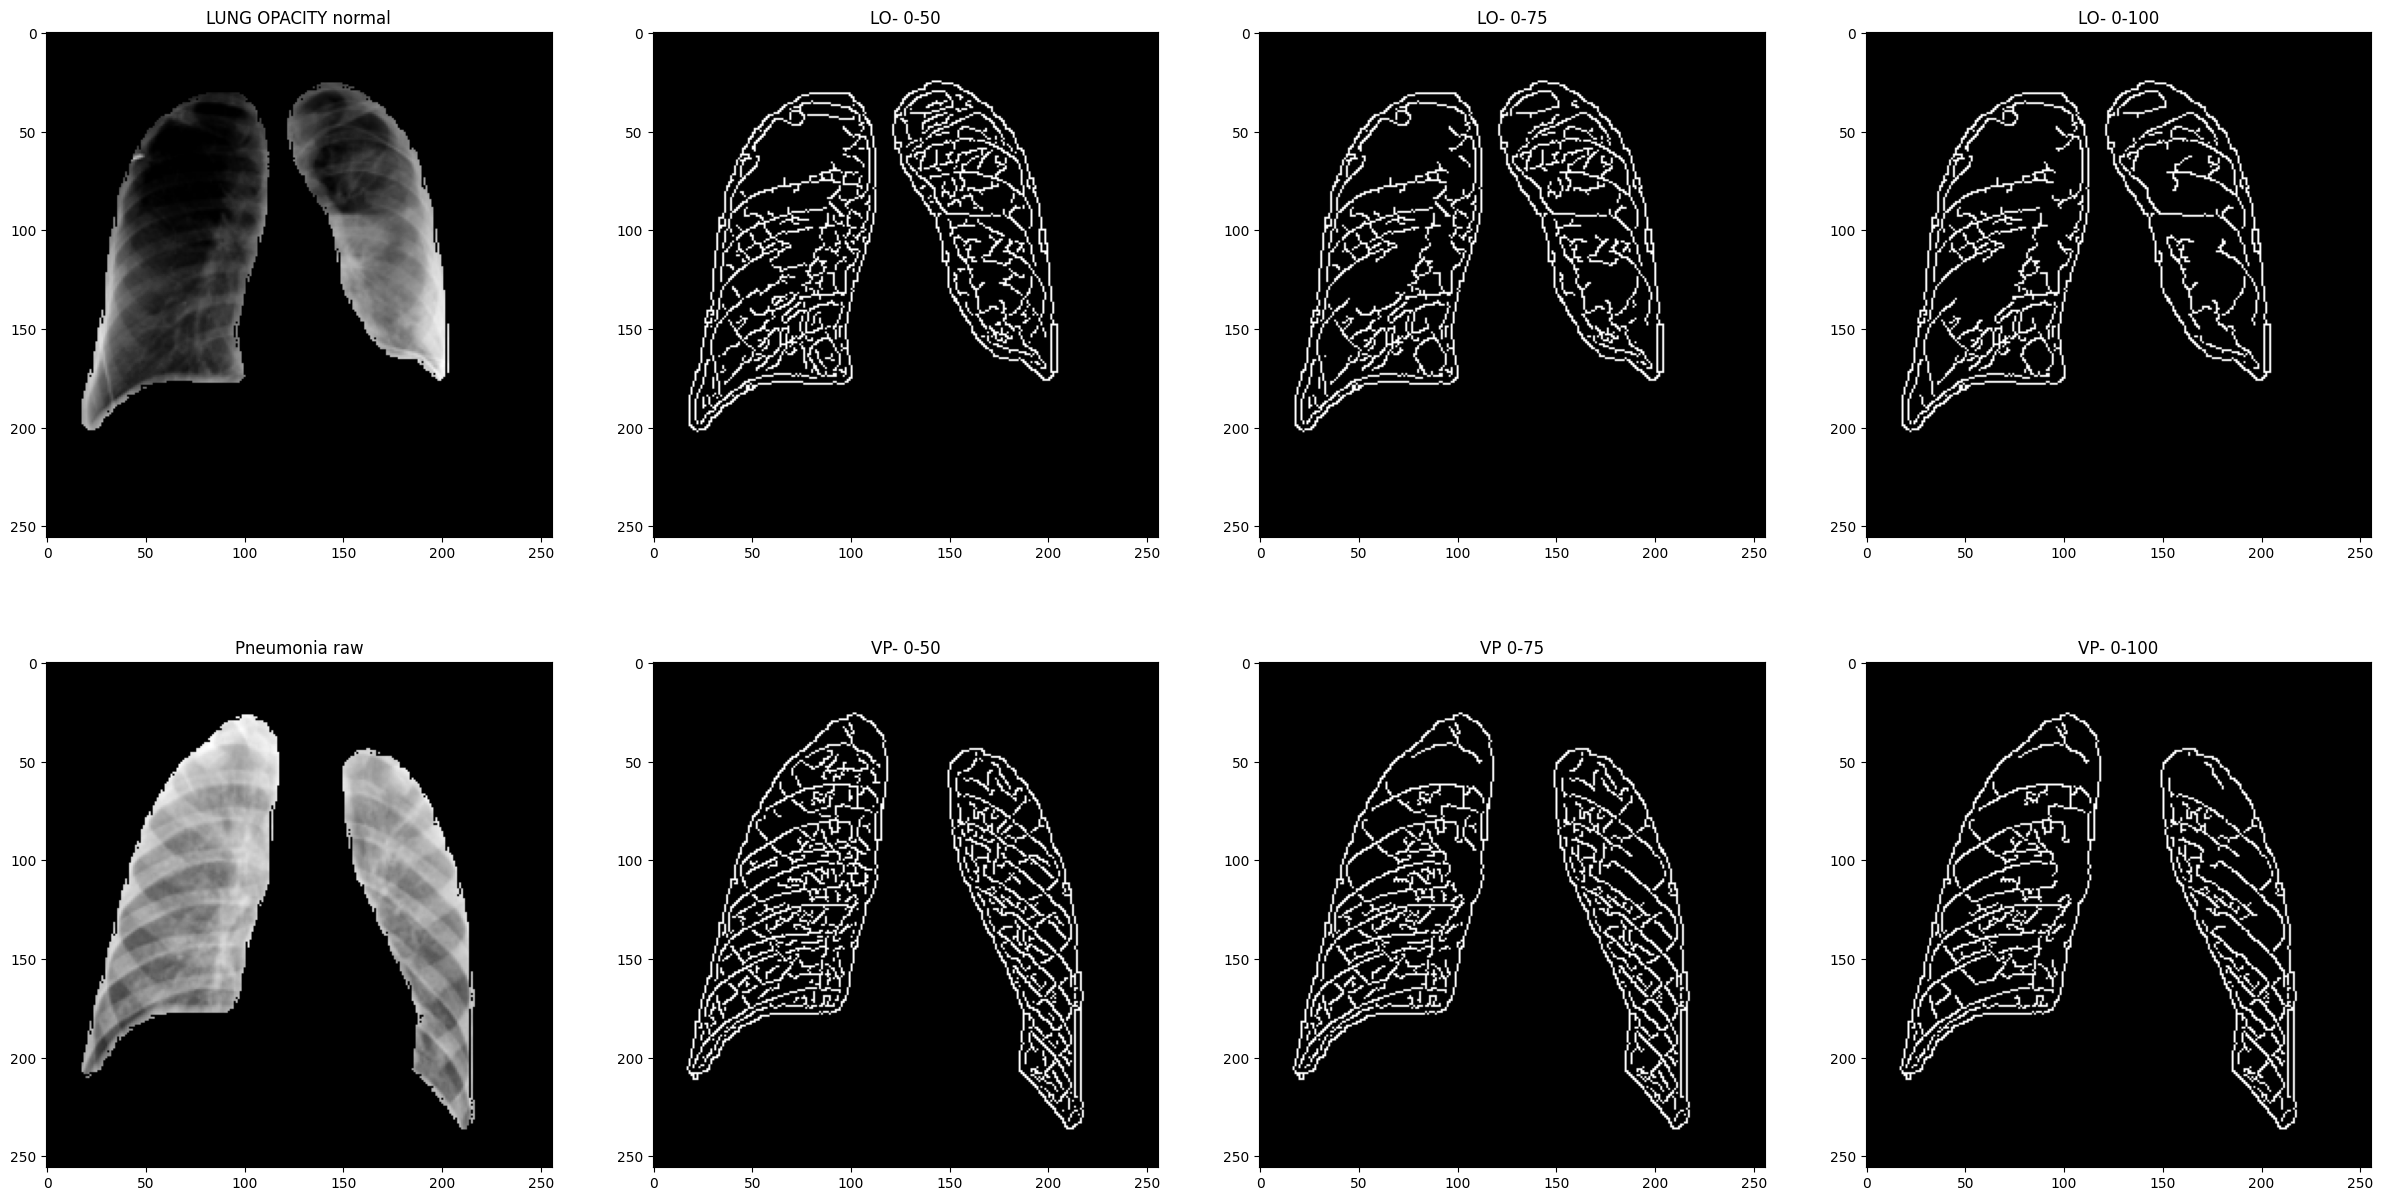

In [12]:
####### +++++++++++++++++++++++++++++++++++++++++++ Detailed analysis of  GAussian blur+ Canny +++++++++++++++++++++++++++++++++++++++++++++++++

####Apply the Gaussian filter- Normal
filter1 = cv2.GaussianBlur(roi_normal, (3, 3), 0)
filter2 = cv2.GaussianBlur(roi_normal, (5, 5), 0)
filter3 = cv2.GaussianBlur(roi_normal, (7, 7), 0)

# Canny filter for normal
edge1 = cv2.Canny(filter1, 0, 50)
edge2 = cv2.Canny(filter1, 0, 75)
edge3 = cv2.Canny(filter1, 0, 100)

####Apply the Gaussian filter-COVID
filter1_covi = cv2.GaussianBlur(roi_covid, (3, 3), 0)
filter2_covi = cv2.GaussianBlur(roi_covid, (5, 5), 0)
filter3_covi = cv2.GaussianBlur(roi_covid, (7, 7), 0)

# Canny filter for COVID
edge1_covi = cv2.Canny(filter1_covi, 0, 50)
edge2_covi = cv2.Canny(filter1_covi, 0, 75)
edge3_covi = cv2.Canny(filter1_covi, 0, 100)

## PLot to check which kernel size is best- Gaussian blur
fig = plt.figure(figsize=(25,15))
plt.subplot(241),plt.imshow(roi_normal, cmap = 'gray'),plt.title('RAw Normal')
plt.subplot(242),plt.imshow(filter1, cmap = 'gray'),plt.title('Gaussian (3, 3)')
plt.subplot(243),plt.imshow(filter2, cmap = 'gray'),plt.title('Gaussian (5, 5)')
plt.subplot(244),plt.imshow(filter3, cmap = 'gray'),plt.title('Gaussian (7, 7)')

plt.subplot(245),plt.imshow(roi_covid, cmap = 'gray'),plt.title('RAw COVID')
plt.subplot(246),plt.imshow(filter1_covi, cmap = 'gray'),plt.title('Gaussian (3, 3)')
plt.subplot(247),plt.imshow(filter2_covi, cmap = 'gray'),plt.title('Gaussian (5, 5)')
plt.subplot(248),plt.imshow(filter3_covi, cmap = 'gray'),plt.title('Gaussian (7, 7)')


####Apply the Gaussian filter-LO
filter1_lo = cv2.GaussianBlur(roi_lo, (3, 3), 0)
filter2_lo = cv2.GaussianBlur(roi_lo, (5, 5), 0)
filter3_lo = cv2.GaussianBlur(roi_lo, (7, 7), 0)


# Canny filter for LO
edge1_lo = cv2.Canny(filter1_lo, 0, 50)
edge2_lo = cv2.Canny(filter1_lo, 0, 75)
edge3_lo = cv2.Canny(filter1_lo, 0, 100)


####Apply the Gaussian filter-VP
filter1_vp = cv2.GaussianBlur(roi_vp, (3, 3), 0)
filter2_vp = cv2.GaussianBlur(roi_vp, (5, 5), 0)
filter3_vp = cv2.GaussianBlur(roi_vp, (7, 7), 0)


# Canny filter for VP
edge1_vp = cv2.Canny(filter1_vp, 0, 50)
edge2_vp = cv2.Canny(filter1_vp, 0, 75)
edge3_vp = cv2.Canny(filter1_vp, 0, 100)


#PLot in a graph
fig = plt.figure(figsize=(15,15))
plt.subplot(141),plt.imshow(edge1, cmap = 'gray'),plt.title('Canny Normal')
plt.subplot(142),plt.imshow(edge1_covi, cmap = 'gray'),plt.title('Canny covid')
plt.subplot(143),plt.imshow(edge1_lo, cmap = 'gray'),plt.title('Canny LO')
plt.subplot(144),plt.imshow(edge1_vp, cmap = 'gray'),plt.title('Canny VP')


#PLot in a graph
fig = plt.figure(figsize=(30,15))

# images
plt.subplot(241)
plt.imshow(roi_normal, cmap="gray")
plt.title('raw normal image')

plt.subplot(242)
plt.imshow(edge1, cmap="gray")
plt.title('Normal 0-50')

plt.subplot(243)
plt.imshow(edge2, cmap = 'gray')
plt.title('Normal 0- 75')

plt.subplot(244)
plt.imshow(edge3, cmap="gray")
plt.title('Normal 0-100')

plt.subplot(245)
plt.imshow(roi_covid, cmap="gray")
plt.title('COVID raw image')

plt.subplot(246)
plt.imshow(edge1_covi, cmap="gray")
plt.title('COVID- 0-50')

plt.subplot(247)
plt.imshow(edge2_covi, cmap="gray")
plt.title('COVID- 0-75')

plt.subplot(248)
plt.imshow(edge3_covi, cmap="gray")
plt.title('COVID raw image')


#PLot in a graph
fig = plt.figure(figsize=(30,15))


plt.subplot(241)
plt.imshow(roi_lo, cmap="gray")
plt.title('LUNG OPACITY normal')

plt.subplot(242)
plt.imshow(edge1_lo, cmap="gray")
plt.title('LO- 0-50')

plt.subplot(243)
plt.imshow(edge2_lo, cmap="gray")
plt.title('LO- 0-75')

plt.subplot(244)
plt.imshow(edge3_lo, cmap="gray")
plt.title('LO- 0-100')

plt.subplot(245)
plt.imshow(roi_vp, cmap="gray")
plt.title('Pneumonia raw')

plt.subplot(246)
plt.imshow(edge1_vp, cmap="gray")
plt.title('VP- 0-50')

plt.subplot(247)
plt.imshow(edge2_vp, cmap="gray")
plt.title('VP 0-75')

plt.subplot(248)
plt.imshow(edge3_vp, cmap="gray")
plt.title('VP- 0-100')

print('A gaussian blur (3, 3) kernel is best along with a Canny between 50 -75 as max')

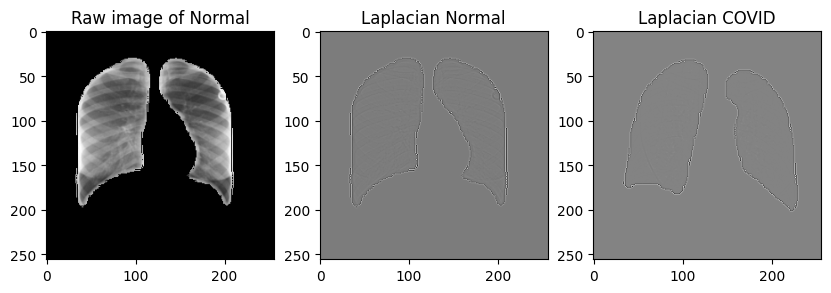

In [13]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############

## Step 5.5: Laplacian filter
def Lap_fil(image):

    xray_lap = cv2.Laplacian(image, ddepth = cv2.CV_64F)# tried ddepth of CV_16S, CV_64F

    return xray_lap

#Test if the function works
normal_Lap_fil = Lap_fil(roi_normal)
covid_Lap_fil =Lap_fil(roi_covid)
#normal_Lap_fil_2 = Lap_fil(roi_normal)
#normal_Lap_fil_3 = Lap_fil(roi_normal)

# plot in graph
fig = plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw image of Normal')
plt.subplot(132),plt.imshow(normal_Lap_fil, cmap = 'gray'),plt.title('Laplacian Normal')
plt.subplot(133),plt.imshow(covid_Lap_fil, cmap = 'gray'),plt.title('Laplacian COVID');

#plt.subplot(144),plt.imshow(normal_Lap_fil_3, cmap = 'gray'),plt.title('Laplacian Normal (ksize 7)')
#plt.xticks([]), plt.yticks([])
#plt.show()

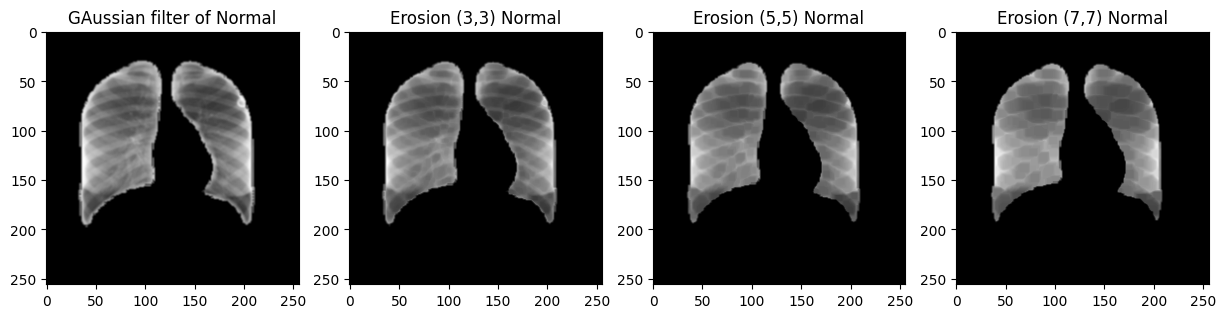

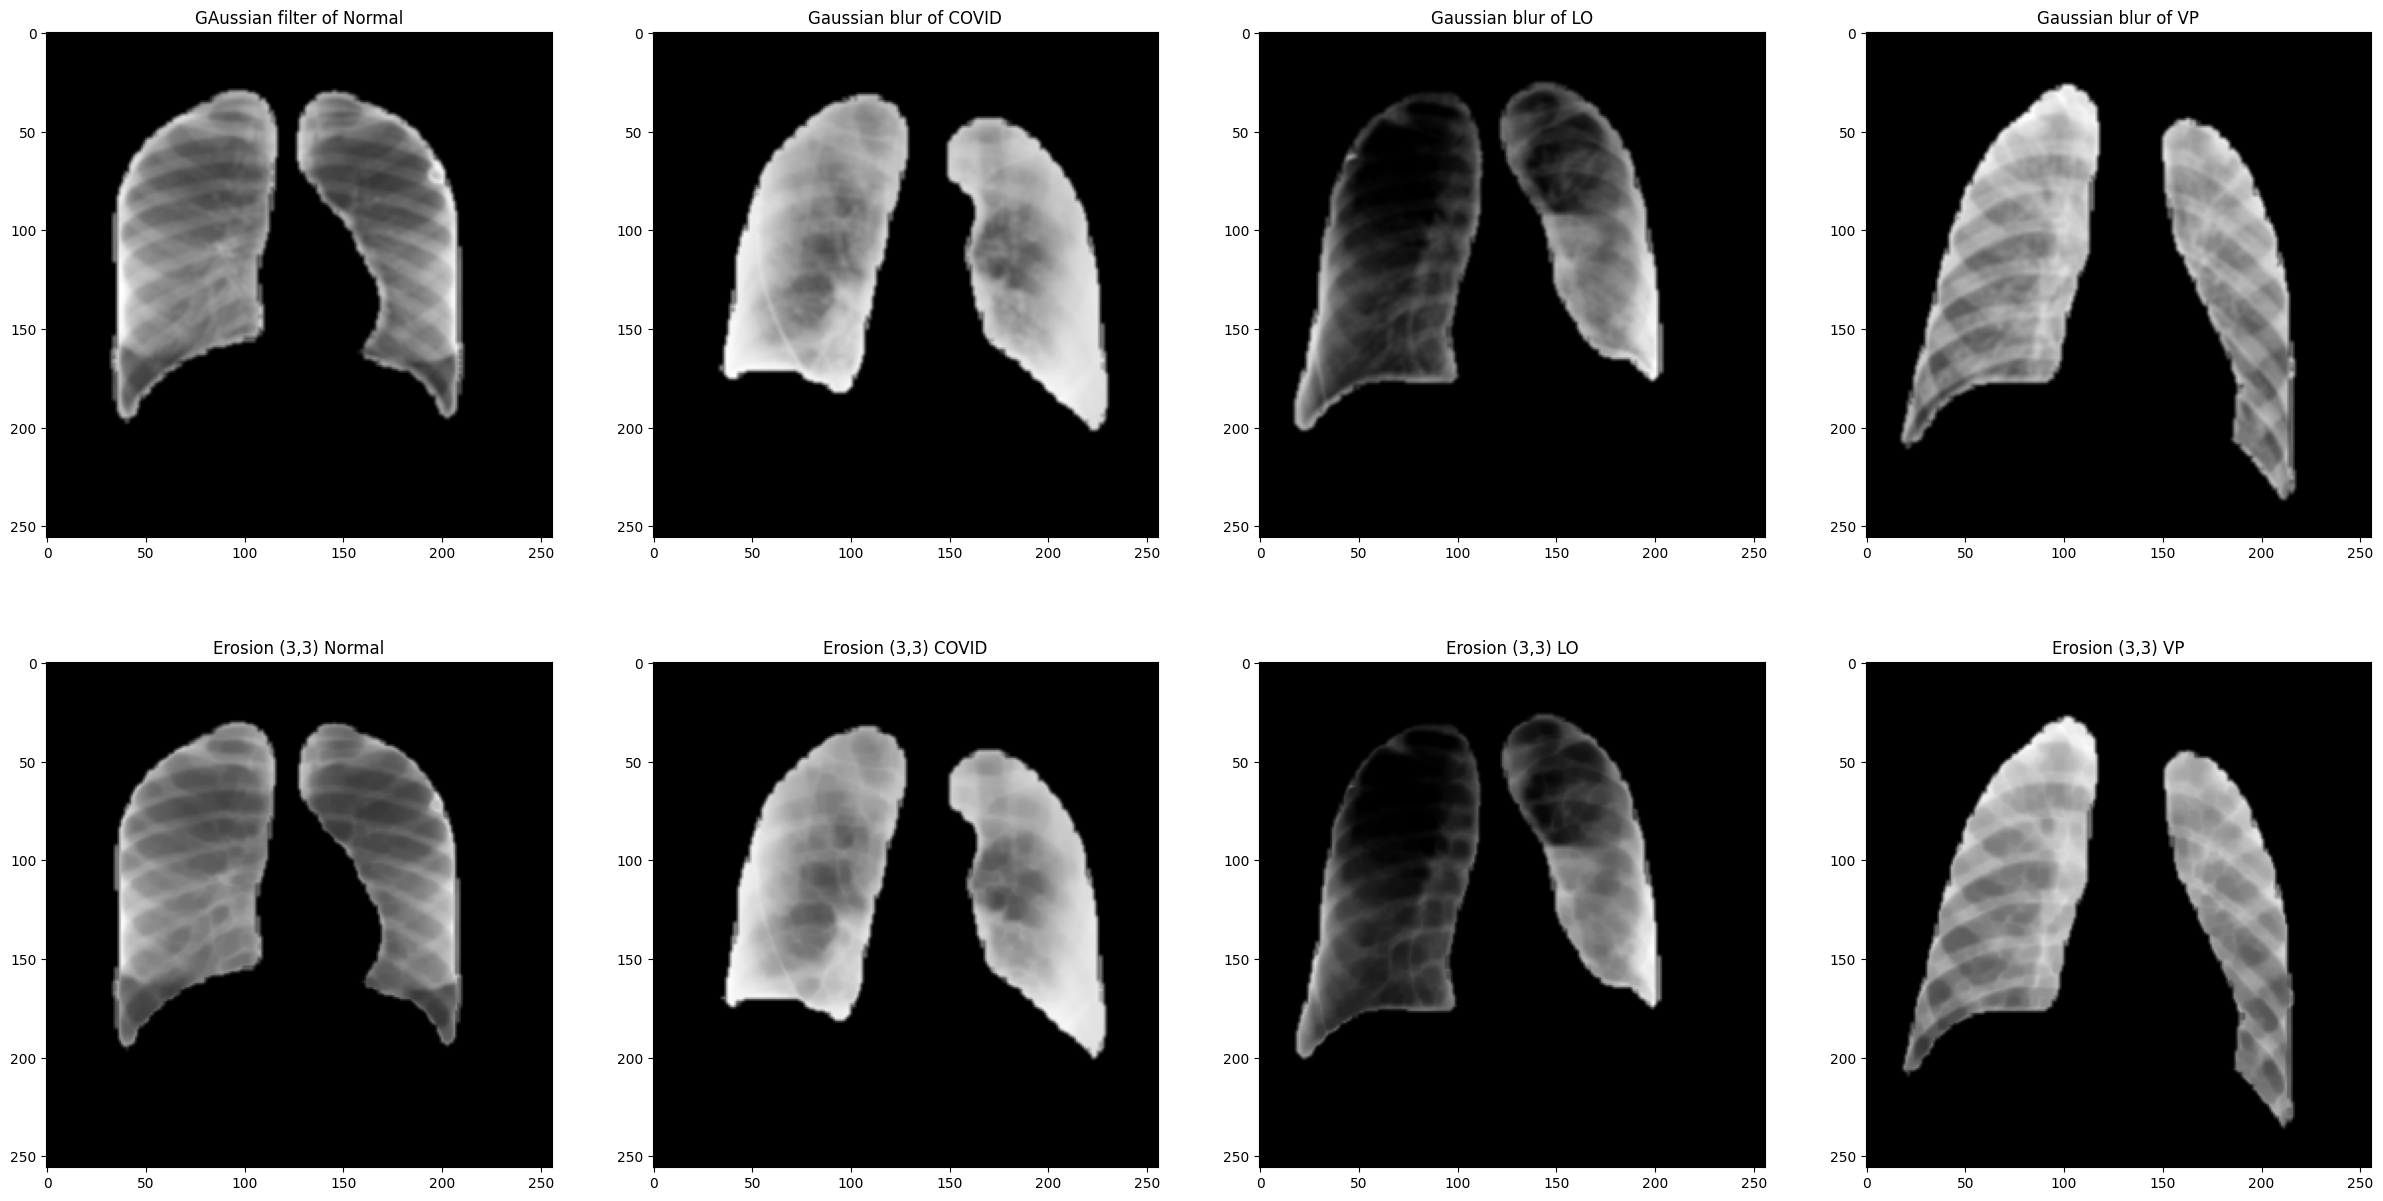

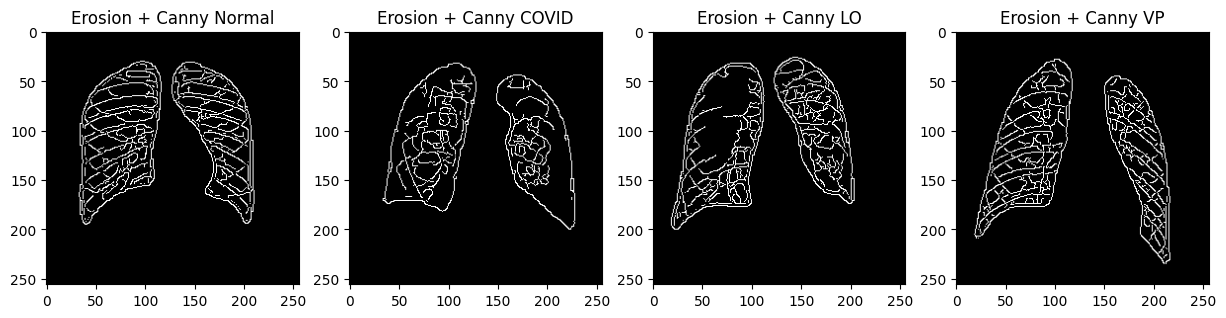

In [14]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############


## Step 5.6: Errosion
# Carry out 3 erosions using the erode function of cv2 using 3 convolution cores composed of only 1 but with respective dimensions (3.3), (5.5) and (7.7).
kernel_1 = np.ones((3, 3), np.uint8)
kernel_2 = np.ones((5, 5), np.uint8)
kernel_3 = np.ones((7, 7), np.uint8)

#Define a function for errosion using the gaussain filtered image as input
def ero_img(image, kernel):

    xray_ero =  cv2.erode(image, kernel)

    return xray_ero

normal_erosion1 = ero_img(normal_Gau, kernel_1)# Looks interesting. Check COVID and LO
normal_erosion2 = cv2.erode(normal_Gau, kernel_2)
normal_erosion3 = cv2.erode(normal_Gau, kernel_3)

covid_erosion = ero_img(covid_Gau, kernel_1)
lo_erosion = ero_img(lo_Gau, kernel_1)
vp_erosion = ero_img(vp_Gau, kernel_1)


# plot in graph
fig = plt.figure(figsize=(15,15))
plt.subplot(241),plt.imshow(normal_Gau, cmap = 'gray'),plt.title('GAussian filter of Normal')
plt.subplot(242),plt.imshow(normal_erosion1, cmap = 'gray'),plt.title('Erosion (3,3) Normal')
plt.subplot(243),plt.imshow(normal_erosion2, cmap = 'gray'),plt.title('Erosion (5,5) Normal')
plt.subplot(244),plt.imshow(normal_erosion3, cmap = 'gray'),plt.title('Erosion (7,7) Normal')



fig = plt.figure(figsize=(30,15))
plt.subplot(241),plt.imshow(normal_Gau, cmap = 'gray'),plt.title('GAussian filter of Normal')
plt.subplot(242),plt.imshow(covid_Gau, cmap = 'gray'),plt.title('Gaussian blur of COVID')
plt.subplot(243),plt.imshow(lo_Gau, cmap = 'gray'),plt.title('Gaussian blur of LO')
plt.subplot(244),plt.imshow(vp_Gau, cmap = 'gray'),plt.title('Gaussian blur of VP')

plt.subplot(246),plt.imshow(covid_erosion, cmap = 'gray'),plt.title('Erosion (3,3) COVID')
plt.subplot(245),plt.imshow(normal_erosion1, cmap = 'gray'),plt.title('Erosion (3,3) Normal')
plt.subplot(247),plt.imshow(lo_erosion, cmap = 'gray'),plt.title('Erosion (3,3) LO')
plt.subplot(248),plt.imshow(vp_erosion, cmap = 'gray'),plt.title('Erosion (3,3) VP')

plt.show()



# One could try edge detection after errosion 
normal_ero_can = canny_fil(normal_erosion1, min_canny = 0, max_canny = 65)
covid_ero_can = canny_fil(covid_erosion, min_canny = 0, max_canny = 65)
lo_ero_can = canny_fil(lo_erosion, min_canny = 0, max_canny = 65)
vp_ero_can = canny_fil(vp_erosion, min_canny = 0, max_canny = 65)


# plot in graph
fig = plt.figure(figsize=(15,15))
plt.subplot(241),plt.imshow(normal_ero_can, cmap = 'gray'),plt.title('Erosion + Canny Normal')
plt.subplot(242),plt.imshow(covid_ero_can, cmap = 'gray'),plt.title('Erosion + Canny COVID')
plt.subplot(243),plt.imshow(lo_ero_can, cmap = 'gray'),plt.title('Erosion + Canny LO')
plt.subplot(244),plt.imshow(vp_ero_can, cmap = 'gray'),plt.title('Erosion + Canny VP');

After trying out different filtering methods, we conclude on the following:

1) Median filter: kernel size (3, 3) blurs the image to a certian extent and a Canny edge detection using a min = 0, max = between 50-75 would be useful. 50 considers noise and 75 eliminates some important structures in the lung. SOmething around 65 should be good
2) Gaussian filter: Functions similar to Median blur.Kernel size 3, and a Canny with min = 0, max = 50-75
3) Laplacian filter : DOes not work at all in our case. It eliminates the outline of important structuresIt will not be used
4) Erosion: Works well with ksize (3, 3) and a Canny min = 0, max = 60

In [15]:
## Step 6: Apply each of the chosen filters to all images and create 3 diff dataframes for testing in models

#Step 6.1: Create an empty list to add image data after applying each filter
median_blur = []


#Step 6.2: Apply the median blur and Canny filter based on former experiments

for image in lung_area:

    # Median blur
    med_blur = cv2.medianBlur(image, 3) # the median blur

    # Canny blur
    canny_med = cv2.Canny(med_blur, 0, 60)

    # Add data in a list
    median_blur.append(canny_med)

# Add data in a df
med_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'median_Canny_img': median_blur})
    

              name   label                                   median_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


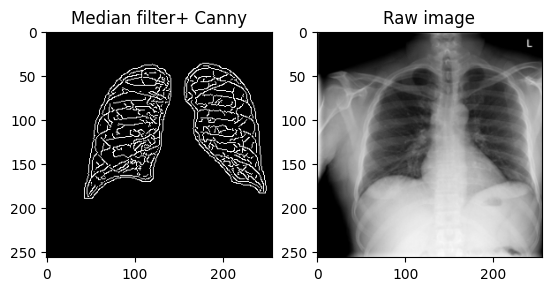

In [16]:
# check the df and check if the images in raw and filtered are the same
print(med_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(med_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(med_canny_lung['median_Canny_img'][i], cmap = 'gray'), plt.title('Median filter+ Canny')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

In [17]:
#Step 6.3: Apply the Gaussian blur + Canny filter

gaussian_blur = []# an empty list
for image in lung_area:

    # Gaussian blur
    gau_blur = cv2.GaussianBlur(image, (3, 3), 0) # the gaussian blur sigmax = 0

    # Canny blur
    canny_gau = cv2.Canny(gau_blur, 0, 65)

    # Add data in a list
    gaussian_blur.append(canny_gau)

# Add data in a df
gau_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'Gau_Canny_img': gaussian_blur})

              name   label                                      Gau_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


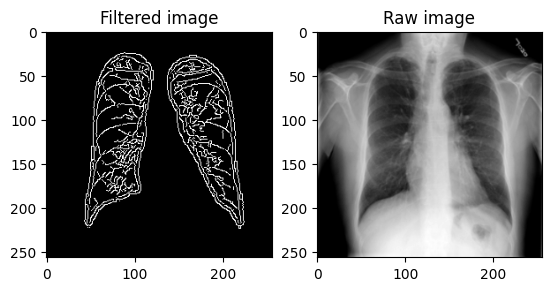

In [18]:
# check the df and check if the images in raw and filtered are the same
print(gau_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(gau_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(gau_canny_lung['Gau_Canny_img'][i], cmap = 'gray'), plt.title('Filtered image')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

In [19]:
#Step 6.4: Apply Erosion + Canny filter

erosion = []# an empty list

for image in lung_area:

    # erosion
    ero = cv2.erode(image,(3, 3)) 

    # Canny blur
    canny_ero = cv2.Canny(ero, 0, 65)

    # Add data in a list
    erosion.append(canny_ero)

# Add data in a df
ero_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'Ero_Canny_img': erosion})

              name   label                                      Ero_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


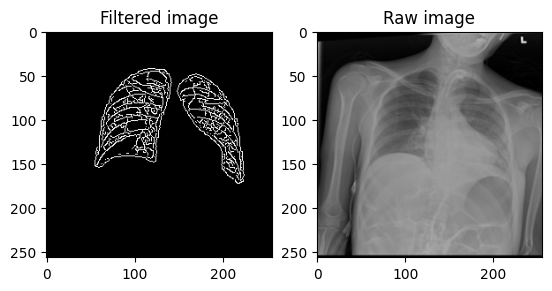

In [20]:
print(ero_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(ero_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(ero_canny_lung['Ero_Canny_img'][i], cmap = 'gray'), plt.title('Filtered image')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

In [21]:
#SInce Gaussian filter is widely used to filter features of X ray images, we decided to proceed with as our preprocessing filter.

# Saving the lung_data df and Gaussian filtered images df as a parquet to make the saving and loading of dfs easy

#import the libraries
from joblib import dump, load

# Save the raw lung data
dump(lung_data, 'raw_lung_data.joblib')


# Save the gaussian filtered lung data
dump(gau_canny_lung, 'filtered_lung_data.joblib')

# Save the dataframe
#lung_data.to_parquet('dataframe.parquet')


# Load the dataframe
#df = pd.read_parquet('dataframe.parquet')

['filtered_lung_data.joblib']

In [22]:
lung_data

name            label  \
0              Normal-6196.png           Normal   
1              Normal-7288.png           Normal   
2              Normal-1821.png           Normal   
3              Normal-4781.png           Normal   
4              Normal-4959.png           Normal   
...                        ...              ...   
21160  Viral Pneumonia-972.png  Viral Pneumonia   
21161  Viral Pneumonia-741.png  Viral Pneumonia   
21162  Viral Pneumonia-999.png  Viral Pneumonia   
21163  Viral Pneumonia-755.png  Viral Pneumonia   
21164  Viral Pneumonia-769.png  Viral Pneumonia   

                                              lung_image  
0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...                                                  ...  
21160  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21161  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21162  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21163  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21164  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[21165 rows x 3 columns]

In [23]:
gau_canny_lung

name            label  \
0              Normal-6196.png           Normal   
1              Normal-7288.png           Normal   
2              Normal-1821.png           Normal   
3              Normal-4781.png           Normal   
4              Normal-4959.png           Normal   
...                        ...              ...   
21160  Viral Pneumonia-972.png  Viral Pneumonia   
21161  Viral Pneumonia-741.png  Viral Pneumonia   
21162  Viral Pneumonia-999.png  Viral Pneumonia   
21163  Viral Pneumonia-755.png  Viral Pneumonia   
21164  Viral Pneumonia-769.png  Viral Pneumonia   

                                           Gau_Canny_img  
0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...                                                  ...  
21160  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21161  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21162  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21163  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
21164  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[21165 rows x 3 columns]